# Imports

In [1]:
import torch
import pandas as pd
import datasets
import evaluate
import numpy as np
from datasets import load_dataset
import ipywidgets as widgets
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from pysentimiento.preprocessing import preprocess_tweet
from sklearn.metrics import classification_report

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

import unicodedata

2024-04-17 11:54:47.494029: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 11:54:47.533457: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 11:54:47.533500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 11:54:47.534918: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-17 11:54:47.542120: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

#pip install torch==2.0.0
#pip install pysentimiento==0.7.2
#pip install evaluate==0.4.0
#pip install datasets==2.14.5
#!pip install unidecode

In [3]:
#!pip install pysentimiento transformers datasets accelerate evaluate

In [4]:
#https://huggingface.co/docs/evaluate/base_evaluator

In [140]:
#Three versions of RoBERTuito were
#trained: a cased version which preserves the case found
#in the original tweets, an uncased version, and a deacc
#version, which lower-cases and removes accents on
#tweets.

In [ ]:
max_length = 128
model_name = "pysentimiento/robertuito-base-deacc"

# Helper Functions

In [7]:
pd.set_option("max_colwidth", 300)

In [141]:
def remove_accents(text):
    return ''.join((c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn'))

In [8]:
# label to name
def label2name(x):
    if x == 0:
        return "Negative"
    if x == 1:
        return "Neutral"
    if x == 2:
        return "Positive"

## Load Dataset

In [ ]:
ds = load_dataset("pyupeu/social-media-peruvian-sentiment")
ds

In [ ]:
# data_files = {"train": "data/train.csv", "validation": "data/val.csv", "test": "data/test.csv"}
# ds = load_dataset("csv", data_files=data_files)

## Performance Metrics

In [9]:
f1_metric = evaluate.load("f1")
recall_metric = evaluate.load("recall")

def compute_metrics (eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis = -1)
    
    results = {}
    results.update(f1_metric.compute(predictions=preds, references = labels, average="macro"))
    results.update(recall_metric.compute(predictions=preds, references = labels, average="macro"))
    return results

In [15]:
#push to hugging face
#https://huggingface.co/settings/tokens
# from huggingface_hub import notebook_login
# notebook_login()

#ds.push_to_hub("jairleo95/social-media-peruvian-sentiment")

In [17]:
ds["train"].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'label_name': Value(dtype='string', id=None),
 'text_original': Value(dtype='string', id=None),
 'tokenized_text': Value(dtype='string', id=None),
 'sent_token_length': Value(dtype='int64', id=None),
 'sent_bert_token_length': Value(dtype='int64', id=None),
 'char_count': Value(dtype='int64', id=None),
 'Character Count': Value(dtype='int64', id=None)}

In [18]:
ds["test"]["label"][:10]

[1, 0, 0, 0, 0, 2, 1, 0, 2, 2]

In [19]:
df = ds['train'].to_pandas()
df.head()

,text,label,label_name,text_original,tokenized_text,sent_token_length,sent_bert_token_length,char_count,Character Count
0,no yuli con eso se va con pendeivis 😞,1,Neutral,No Yuli con eso se va con pendeivis 😞,no yuli con eso se va con pendeivis 😞,9,12,37,37
1,este es más bruto... cosas que necesita el perú obio que se importara.. todo lo que tienes que decir para que gané kk.. mariposa 🦋 gorda... !️,0,Negative,Este es más bruto... Cosas que necesita el Perú obio que se importara.. Todo lo que tienes que decir para que gané KK.. Mariposa 🦋 GORDA... ‼️,este es más bruto cosas que necesita el perú obio que se importara todo lo que tienes que decir para que gané kk mariposa 🦋 gorda ️,27,35,144,144
2,"bakan tu video pero el chambar es riko pero para puesto 1 no va ah, el caldo blanco es mucho mas sabroso, sin mencionar la infinidad de sopas, caldos y chupes q se prepara en arequipa como el chaque de tripas, el puchero o el timpo de rabos etc etc, saludos compare 👍",2,Positive,"Bakan tu video pero el chambar es riko pero para puesto 1 no va ah, el caldo blanco es mucho mas sabroso, sin mencionar la infinidad de sopas, caldos y chupes q se prepara en arequipa como el chaque de tripas, el puchero o el timpo de rabos etc etc, saludos compare 👍",bakan tu video pero el chambar es riko pero para puesto 1 no va ah el caldo blanco es mucho mas sabroso sin mencionar la infinidad de sopas caldos y chupes q se prepara en arequipa como el chaque de tripas el puchero o el timpo de rabos etc etc saludos compare 👍,53,67,267,267
3,no sabes que hacer para llamar la atención para que te dean bola en tus canciones copiada 🤮🤮🤮,0,Negative,no sabes que hacer para llamar la atención para que te dean bola en tus canciones copiada 🤮🤮🤮🤮,no sabes que hacer para llamar la atención para que te dean bola en tus canciones copiada 🤮🤮🤮,18,20,93,93
4,"pe chino dame chamba mano, almenos pa limpiarte las tabas :v🥺",1,Neutral,"Pe CHINO DAME CHAMBA MANO, ALMENOS PA LIMPIARTE LAS TABAS :V🥺",pe chino dame chamba mano almenos pa limpiarte las tabas v🥺,11,14,61,61


## Model and Tokenizer

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.model_max_length = max_length

/home/darkstar/anaconda3/envs/robertuito-env/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Pre processing

In [21]:
# encode label and mapping label name
#df["label"] = df["label"].apply(lambda x: label_encode(x))
df["label_name"] = df["label"].apply(lambda x: label2name(x))

# remove accents
df["text"] = df["text"].apply(lambda x: remove_accents(x))
df.sample(10)

In [25]:
preprocessed_ds = ds.map(lambda ex: {"text": preprocess_tweet(ex["text"], lang="es")})

In [26]:
tokenized_ds = preprocessed_ds.map(
    lambda batch: tokenizer(
        batch["text"], padding=True, truncation=True
        ),
    batched=True, batch_size=32
)
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'text_original', 'tokenized_text', 'sent_token_length', 'sent_bert_token_length', 'char_count', 'Character Count', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7594
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'text_original', 'tokenized_text', 'sent_token_length', 'sent_bert_token_length', 'char_count', 'Character Count', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2374
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'text_original', 'tokenized_text', 'sent_token_length', 'sent_bert_token_length', 'char_count', 'Character Count', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1899
    })
})

In [28]:
tokenized_ds['train']['input_ids'][0][::10]

[0, 614, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [29]:
tokenized_ds['train']['attention_mask'][0][::10]

[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [30]:
tokenized_ds['train']['text'][10]

'tu hermano gemelo manolo... sobrado la haces como su doble..   emoji cara con mano sobre la boca emoji  emoji cara con mano sobre la boca emoji'

In [31]:
tokenized_ds['train']['token_type_ids'][0][:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [32]:
#tokenizer.get_vocab()

In [33]:
df_slangs = pd.read_csv(r'../text-extraction/peruvian-slang.v1.csv')
df_slangs

,nro,Jerga,tipo,descripción corta,Descripción,fuente
0,1,Pe,Jerga,Pues,"""Pe"", por su parte, no es otra cosa que la versión peruana del ""pues"" o el ""po"" chileno. Generalmente va al final de la frase en casos como ""¿Qué pasa, pe?"" o ""Nos vemos el sábado / Ya, pe"".",https://www.bbc.com/mundo/noticias-50213086
1,2,Oe,Jerga,Oye,"""Oe"" es el ""oye"" u ""oíme"" que en otros países hispanohablantes usan al interactuar con otra persona: ""¡Oe! ¿Y qué quieres hacer?"" o ""Pero hazme caso, oe"".",https://www.bbc.com/mundo/noticias-50213086
2,3,Lechero,Jerga,mucha suerte,Dicese de aquella persona que tiene mucha suerte / tambien se le dice a aquella persona que le gusta tener mucho sexo,https://www.bbc.com/mundo/noticias-50213086
3,4,Lenteja,Jerga,muy lento,Persona u objeto lento.,https://www.bbc.com/mundo/noticias-50213086
4,5,Tirarse la pera,expresión,ausentarse,Faltar injustificadamente al centro de trabajo o estudios,https://www.bbc.com/mundo/noticias-50213086
...,...,...,...,...,...,...
2339,2340,Meter floro o florear,expresión,Distorsionar la verdad para convencer a alguien.,Distorsionar la verdad para convencer a alguien.,NaN
2340,2341,Tus perras están ladrando,expresión,Los pies de una persona tienen un olor desagradable.,Los pies de una persona tienen un olor desagradable.,NaN
2341,2342,Hacer una chancha,expresión,Recolecta de dinero entre amigos.,Recolecta de dinero entre amigos.,NaN
2342,2343,Pitri mitri,expresión,Algo es asombroso.,Algo es asombroso.,NaN


In [131]:
df_slangs.sample(20)

,nro,Jerga,tipo,descripción corta,Descripción,fuente
29,30,mondongo,Jerga,grasa en la cintura,grasa en la cintura,https://www.lima2019.pe/magazine/milco-guia-las-jergas-peruanas-mas-usadas-para-entendernos-en-lima2019
53,54,ditroi,Jerga,sexo,tener sexo,https://jergozo.com/diccionario-peruano
847,848,guasamandrapa,Jerga,pene,Pene,https://jergozo.com/diccionario-peruano
1270,1271,ómnibus,Jerga,bus,Autobús urbano o local.,https://jergozo.com/diccionario-peruano
205,206,cacho,Jerga,que tiene relaciones sexuales,"Cuando un hombre y una mujer tienen relaciones sexuales, pero dicho de forma vulgar, muchos piensan que es un palabra obsceno",https://jergozo.com/diccionario-peruano
1799,1800,tonazo,Jerga,fiesta,Gran fiesta,https://jergozo.com/diccionario-peruano
281,282,carcumena,Jerga,mugrienta,Persona que no se baña despues de años,https://jergozo.com/diccionario-peruano
2270,2271,chapar,Jerga,besar,"1. Besar. / Los vieron chapando a la vuelta de la esquina, 2. Agarrar, coger, tomar, asir. / Anda a la esquina y chapa el bus de color azul, ese te lleva. / Chapa tu cartera, no vayas a dejarla, 3. Atrapar. / Y al final, después de tanto correteo, los policías chaparon al choro.",https://www.wikilengua.org/index.php/Jerga_juvenil/Per%C3%BA
2241,2242,chato,Jerga,de baja estatura,"corto, usado para describir a una persona (a menudo usado como apodo).",https://www.jerga.net/jerga-peruana/
625,626,de pinga,expresión,pene,Órgano sexual masculino. Se usa en grupos marginales y se considera más que una palabra altisonante una grosería.,https://jergozo.com/diccionario-peruano


In [35]:
df_slangs['Jerga'] = df_slangs['Jerga'].apply(lambda x: x.lower())
slangs = df_slangs['Jerga'].values.tolist()

In [36]:
len(slangs)

2344

In [37]:
tokenizer.unk_token

'<unk>'

In [38]:
#import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model.cuda()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [39]:
tokenized_ds['train']

Dataset({
    features: ['text', 'label', 'label_name', 'text_original', 'tokenized_text', 'sent_token_length', 'sent_bert_token_length', 'char_count', 'Character Count', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7594
})

In [40]:
len(tokenized_ds['train']['input_ids'][0])

128

In [44]:
len(tokenized_ds['train']['input_ids'][2222])

103

In [45]:
(tokenized_ds['train']['text'][2222])

'cristian ya fuistes a partir de ahora será así emoji cara con ojos en blanco emoji  emoji cara llorando de risa emoji  emoji cara llorando de risa emoji  emoji cara revolviéndose de la risa emoji  emoji cara revolviéndose de la risa emoji'

In [46]:
len(tokenized_ds['train']['input_ids'][2222])

103

In [47]:
len(tokenizer)

30000

In [48]:
tokenized_ds['train']['text_original'][2134]

'Ximena Ariana Yolanda para nuestros lonchesitos 😍'

In [49]:
tokenizer.add_tokens(slangs)

2337

In [50]:
old_tokenizer = AutoTokenizer.from_pretrained(model_name)

In [53]:
text = "gorda sexy, mi queridisimo huevera eh chancho chichero 🤣😂🤣😂, que hay de tus comentario?"
old_tokenizer.tokenize(text)

['▁gorda',
 '▁sex',
 'y,',
 '▁mi',
 '▁quer',
 'id',
 'isimo',
 '▁hue',
 'vera',
 '▁eh',
 '▁chan',
 'cho',
 '▁chich',
 'ero',
 '▁,',
 '▁que',
 '▁hay',
 '▁de',
 '▁tus',
 '▁comentario',
 '?']

In [54]:
tokenizer.tokenize(text)

['▁gorda',
 '▁sex',
 'y,',
 '▁mi',
 '▁quer',
 'i',
 'di',
 '▁si',
 'mo',
 '▁',
 'huevera',
 '▁eh',
 '▁',
 'chancho',
 '▁',
 'chichero',
 '▁,',
 '▁que',
 '▁hay',
 '▁de',
 '▁tus',
 '▁co',
 'men',
 '▁ta',
 'rio',
 '▁?']

In [55]:
new_vocab = tokenizer.vocab
new_vocab['▁comentario']

5053

In [56]:
old_vocab = old_tokenizer.vocab
old_vocab['▁comentario']

5053

In [57]:
old_tokenizer.add_tokens(['malardo'])

1

In [58]:
old_tokenizer.tokenize('donde estas cholita')

['▁donde', '▁estas', '▁chol', 'ita']

In [59]:
tokenizer.tokenize('donde estas cholita')

['don', '▁de', '▁estas', '▁', 'cholita']

In [60]:
tokenizer.convert_ids_to_tokens([19333,10130])

['▁alergia', '▁termo']

In [61]:
tokenizer.convert_tokens_to_string(['▁alergia', '▁termo'])

'alergia termo'

In [62]:
# old_tokenizer.vocab

In [63]:
gigachad_tokenizer = AutoTokenizer.from_pretrained("pyupeu/robertuito-peruvian-sentiment")

In [64]:
len(gigachad_tokenizer)

30621

In [65]:
gigachad_tokenizer.tokenize('donde estas cholita')

['▁donde', '▁estas', '▁chol', 'ita']

In [66]:
df_slangs.sample(10)

,nro,Jerga,tipo,descripción corta,Descripción,fuente
214,215,caficho,Jerga,proxeneta,"Proxeneta. persona que vive de una mujer , vividor",https://jergozo.com/diccionario-peruano
529,530,combazo,Jerga,golpe fuerte,"Combo, puñetazo.",https://jergozo.com/diccionario-peruano
384,385,chicote,Jerga,latigo,latigo,https://jergozo.com/diccionario-peruano
131,132,bembón,Jerga,boca grande,boca grande,https://jergozo.com/diccionario-peruano
672,673,emilio,Jerga,mail,Email,https://jergozo.com/diccionario-peruano
1,2,oe,Jerga,Oye,"""Oe"" es el ""oye"" u ""oíme"" que en otros países hispanohablantes usan al interactuar con otra persona: ""¡Oe! ¿Y qué quieres hacer?"" o ""Pero hazme caso, oe"".",https://www.bbc.com/mundo/noticias-50213086
1759,1760,ternera,Jerga,Terno,Terno,https://jergozo.com/diccionario-peruano
148,149,blogoyop,Jerga,felación,felación,https://jergozo.com/diccionario-peruano
1301,1302,pálpito,Jerga,Corazonada.,Corazonada.,https://jergozo.com/diccionario-peruano
944,945,huilla,Jerga,bebida,Trago fuerte de antaÑo de lima,https://jergozo.com/diccionario-peruano


In [133]:
tokenizer.tokenize(' timbero')

['▁', 'timbero']

## Training

In [68]:
model.resize_token_embeddings(len(tokenizer))#https://huggingface.co/docs/transformers/main_classes/tokenizer

Embedding(32282, 768)

In [69]:
training_args = TrainingArguments(
    output_dir="robertuito_deacc/checkpoints",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=1,
    weight_decay=0.01,
    warmup_ratio=0.1,
    learning_rate=5e-5,
    do_eval=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=7,
    load_best_model_at_end=True,
    # save_total_limit=2,
    group_by_length=True,
    seed=1
)

In [70]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
)

/home/darkstar/anaconda3/envs/robertuito-env/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [71]:
trainer.train()

{'eval_loss': 0.6153641939163208, 'eval_f1': 0.7200333511452762, 'eval_recall': 0.7196836073836989, 'eval_runtime': 10.5446, 'eval_samples_per_second': 225.139, 'eval_steps_per_second': 14.13, 'epoch': 1.0}
{'eval_loss': 0.6478086113929749, 'eval_f1': 0.7309890530658705, 'eval_recall': 0.7354088897809267, 'eval_runtime': 10.5066, 'eval_samples_per_second': 225.953, 'eval_steps_per_second': 14.182, 'epoch': 2.0}
{'loss': 0.5937, 'grad_norm': 2.5980465412139893, 'learning_rate': 3.889259506337559e-05, 'epoch': 2.1}
{'eval_loss': 0.8504292368888855, 'eval_f1': 0.7246000386071548, 'eval_recall': 0.7267999792148471, 'eval_runtime': 10.8176, 'eval_samples_per_second': 219.457, 'eval_steps_per_second': 13.774, 'epoch': 3.0}
{'eval_loss': 1.142120122909546, 'eval_f1': 0.716744251501464, 'eval_recall': 0.7171400921655646, 'eval_runtime': 10.4591, 'eval_samples_per_second': 226.979, 'eval_steps_per_second': 14.246, 'epoch': 4.0}
{'loss': 0.144, 'grad_norm': 0.4269181787967682, 'learning_rate': 2

TrainOutput(global_step=1666, training_loss=0.22882591790798046, metrics={'train_runtime': 837.0685, 'train_samples_per_second': 63.505, 'train_steps_per_second': 1.99, 'train_loss': 0.22882591790798046, 'epoch': 7.0})

In [135]:
# Save trained model
trainer.model.save_pretrained("robertuito_deacc/model")

In [136]:
from huggingface_hub import notebook_login

notebook_login()

In [138]:
model.push_to_hub("pyupeu/robertuito-peruvian-sentiment")

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/pyupeu/robertuito-peruvian-sentiment/commit/152dd5cd5c58050ced05631455756e1d85863ff5', commit_message='Upload RobertaForSequenceClassification', commit_description='', oid='152dd5cd5c58050ced05631455756e1d85863ff5', pr_url=None, pr_revision=None, pr_num=None)

## Test on validation set

In [128]:
#https://machinelearningmastery.com/gentle-introduction-to-the-bias-variance-trade-off-in-machine-learning/

In [129]:
# model.load_state_dict(torch.load(f'./robertuito_deacc/model', map_location=torch.device('cpu')))

In [74]:
evaluation_results = trainer.evaluate(tokenized_ds["test"])

{'eval_loss': 0.6019187569618225, 'eval_f1': 0.7266343808786871, 'eval_recall': 0.7274796361657465, 'eval_runtime': 8.3366, 'eval_samples_per_second': 227.792, 'eval_steps_per_second': 14.274, 'epoch': 7.0}


In [75]:
evaluation_results

{'eval_loss': 0.6019187569618225,
 'eval_f1': 0.7266343808786871,
 'eval_recall': 0.7274796361657465,
 'eval_runtime': 8.3366,
 'eval_samples_per_second': 227.792,
 'eval_steps_per_second': 14.274,
 'epoch': 7.0}

In [76]:
predictions = trainer.predict(tokenized_ds["test"])
predictions

PredictionOutput(predictions=array([[ 0.8936414 ,  0.9935377 , -1.8226446 ],
       [-1.3423645 ,  0.19635049,  1.7433056 ],
       [ 0.77376103,  0.1690881 , -1.0534034 ],
       ...,
       [-2.2303078 ,  0.0546267 ,  2.9435313 ],
       [-1.2354444 ,  0.52282125,  0.8276019 ],
       [ 1.5713189 ,  0.43699783, -2.0392601 ]], dtype=float32), label_ids=array([1, 0, 0, ..., 2, 1, 0]), metrics={'test_loss': 0.6019187569618225, 'test_f1': 0.7266343808786871, 'test_recall': 0.7274796361657465, 'test_runtime': 8.37, 'test_samples_per_second': 226.881, 'test_steps_per_second': 14.217})

In [77]:
len(predictions[0])

1899

In [78]:
true_labels = tokenized_ds["test"]['label']

In [79]:
len(true_labels)

1899

In [80]:
predicted_labels = [np.argmax(pred) for pred in predictions[0]]
classification_rep = classification_report(true_labels, predicted_labels, digits=5)

print(classification_rep)

              precision    recall  f1-score   support

           0    0.82992   0.80025   0.81481       811
           1    0.60870   0.63406   0.62112       552
           2    0.73985   0.74813   0.74397       536

    accuracy                        0.73723      1899
   macro avg    0.72616   0.72748   0.72663      1899
weighted avg    0.74019   0.73723   0.73852      1899



# Error Analisys

In [83]:
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
val_df = ds['validation'].to_pandas()

In [84]:
# We do this to view predictions in the pandas dataframe and easily filter them and perform error analysis.
pred_final = []

for i, row in tqdm(val_df.iterrows(), total=val_df.shape[0]):
    predictions = []

    text = row["text"]
    encoded_data_test_single = tokenizer.batch_encode_plus([text], 
    # add_special_tokens=config.add_special_tokens, 
    # return_attention_mask=config.return_attention_mask, 
    # pad_to_max_length=config.pad_to_max_length, 
    max_length=128,
    # return_tensors=config.return_tensors
    return_tensors="pt"
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']

    
    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():        
        outputs = model(**inputs)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

  0%|          | 0/2374 [00:00<?, ?it/s]

In [85]:
# add pred into val_df
val_df["pred"] = pred_final

In [86]:
#  Add control column for easier wrong and right predictions
control = val_df.pred.values == val_df.label.values
val_df["control"] = control

In [87]:
# filtering false predictions
#val_df = val_df[val_df.control == False]

In [88]:
# label to intent mapping
name2label = {"Negative":0,
              "Neutral":1,
             "Positive":2
             }
label2name = {v: k for k, v in name2label.items()}

val_df["pred_name"] = val_df.pred.apply(lambda x: label2name.get(x)) 

In [89]:

# We create a confusion matrix to better observe the classes that the model confuses.
pred_name_values = val_df.pred_name.values
label_values = val_df.label_name.values
confmat = confusion_matrix(label_values, pred_name_values, labels=list(name2label.keys()))

In [90]:
confmat

array([[457, 522,  34],
       [ 60, 580,  51],
       [ 20, 372, 278]])

In [91]:
df_confusion_val = pd.crosstab(label_values, pred_name_values)
df_confusion_val

col_0,Negative,Neutral,Positive
row_0,,,
Negative,457,522,34
Neutral,60,580,51
Positive,20,372,278


In [92]:
# save confusion matrix df
df_confusion_val.to_csv("val_df_confusion.csv")

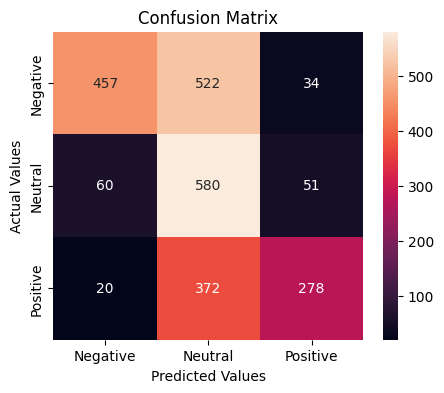

In [93]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(label_values, pred_name_values)
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True,fmt=".0f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [94]:
val_df.to_csv('train_validation.csv', columns=['text', 'label', 'char_count', 'pred', 'control', 'pred_name'])

## Inference

In [121]:
tokenized_ds['test']['text'][:20]

['y cuantas chanchas habran hecho para la salvadora de la democracia?.. emoji cara pensativa emoji',
 'tremenda joyita  emoji corazón morado emoji  emoji corazón morado emoji  emoji corazón morado emoji',
 'entre cabros se entienden altamirano gómez alain gerard... y de pasadita dale su beso y mepaso en su pelacho a la beto...  emoji cara llorando de risa emoji',
 'chino llevalo al camal, a ese puerco  emoji cara revolviéndose de la risa emoji  emoji cara revolviéndose de la risa emoji',
 'apoyo de 4 gato y un perro con virolo... emoji cara sonriente con lágrima emoji  emoji cara sonriendo con sudor frío emoji',
 'me enamore gente, después de ver full ch0las en stream me limpiastes los ojos',
 'henry loyola como cuando te digo "bebé se me ve bien" o "bebé buscame otra talla" y tú no colaboras amor   emoji cara decepcionada emoji  emoji cara decepcionada emoji  emoji cara decepcionada emoji',
 'esté cabeza de chancho  emoji nariz de cerdo emoji  burro',
 'lo de los instrumentos musicale

In [97]:
test_df = ds['test'].to_pandas()

## Evaluate the Model Qualitatively (Human Evaluation)

## Evaluate the Model Quantitatively (with F1 Metric)

In [100]:
texts = test_df[0:20]['text']
human_baseline_labels = test_df[0:20]['label']

In [101]:
texts

0                                                                                                                                                                                                                                        y cuantas chanchas habran hecho para la salvadora de la democracia?..🤔
1                                                                                                                                                                                                                                                                                           tremenda joyita 💜💜💜
2                                                                                                                                                                                   entre cabros se entienden altamirano gómez alain gerard... y de pasadita dale su beso y mepaso en su pelacho a la beto... 😂
3                                                                                       

In [102]:
human_baseline_labels

0     1
1     0
2     0
3     0
4     0
5     2
6     1
7     0
8     2
9     2
10    2
11    0
12    0
13    0
14    2
15    0
16    0
17    0
18    2
19    0
Name: label, dtype: int64

In [103]:
def get_prediction(text):
    input_ids = tokenizer(text, return_tensors="pt", max_length=128).input_ids.to('cuda')
    logits = model(input_ids).logits
    probabilities = logits.softmax(dim=-1).tolist()[0]
    return np.argmax(probabilities).flatten()[0]

In [104]:
#original_model_summaries = []
model_classifications = []
for _, text in enumerate(texts):
    model_classifications.append(get_prediction(text))

In [122]:
model_classifications

[1, 2, 1, 0, 0, 2, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 1, 1]

## Step by step predictions on dataframe

In [106]:
# We do this to view predictions in the pandas dataframe and easily filter them and perform error analysis.
pred_test_final = []

for i, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    predictions = []

    text = row["text"]
    encoded_data_test_single = tokenizer.batch_encode_plus([text], 
    # add_special_tokens=config.add_special_tokens, 
    # return_attention_mask=config.return_attention_mask, 
    # pad_to_max_length=config.pad_to_max_length, 
    max_length=128,
    # return_tensors=config.return_tensors
    return_tensors="pt"
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']

    
    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():        
        outputs = model(**inputs)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_test_final.append(np.argmax(predictions, axis=1).flatten()[0])

  0%|          | 0/1899 [00:00<?, ?it/s]

In [107]:
len(pred_test_final)

1899

In [108]:
test_df.size

17091

In [109]:
# add pred into val_df
test_df["pred"] = pred_test_final

In [110]:
# label to intent mapping
name2label = {"Negative":0,
              "Neutral":1,
             "Positive":2
             }
label2name = {v: k for k, v in name2label.items()}

test_df["pred_name"] = test_df.pred.apply(lambda x: label2name.get(x)) 

In [120]:
test_df.sample(20)

,text,label,label_name,text_original,tokenized_text,sent_token_length,sent_bert_token_length,char_count,Character Count,pred,pred_name
1706,"se puso roja de colera😂😂,que pena que haya perdido una gran ventana para exponer las propuestas de su partido,ella lo quiso asi!!🤷‍️",1,Neutral,"Se puso roja de colera😂😂,que pena que haya perdido una gran ventana para exponer las propuestas de su partido,ella lo quiso asi!!🤷‍♀️",se puso roja de colera😂😂 que pena que haya perdido una gran ventana para exponer las propuestas de su partido ella lo quiso asi 🤷‍️,22,26,132,132,1,Neutral
832,manolo del castillo (oficial) sorojchi pills capsulas para la próxima 😁,1,Neutral,Manolo Del Castillo (Oficial) Sorojchi pills capsulas para la próxima 😁,manolo del castillo oficial sorojchi pills capsulas para la próxima 😁,11,19,71,71,1,Neutral
286,"😆🤭eres única pía para que amargarse se nos arruga la piel, eso lo dejamos para las amargadas",2,Positive,"😆🤭eres única pía para que amargarse se nos arruga la piel, eso lo dejamos para las amargadas",😆🤭eres única pía para que amargarse se nos arruga la piel eso lo dejamos para las amargadas,17,21,92,92,0,Negative
1051,"ya, está bien pero el 11 y 33? 😂 habla pe o te vas a seguir haciéndote el cojudo. (no digo que no te salga increíble el papel de cojudo)",0,Negative,"Ya, está bien pero el 11 y 33? 😂 Habla pe o te vas a seguir haciéndote el cojudo. (No digo que no te salga increíble el papel de cojudo)",ya está bien pero el 11 y 33 😂 habla pe o te vas a seguir haciéndote el cojudo no digo que no te salga increíble el papel de cojudo,30,37,136,136,1,Neutral
993,mario jesus qui ba nuestro huequito hace años ufff 🤤🤤🤤 amor date un tiempo extraño mi combinadito 😪😪,2,Positive,Mario Jesus Qui Ba nuestro huequito hace años ufff 🤤🤤🤤 amor date un tiempo extraño mi combinadito 😪😪,mario jesus qui ba nuestro huequito hace años ufff 🤤🤤🤤 amor date un tiempo extraño mi combinadito 😪😪,18,20,100,100,1,Neutral
589,¡pero si a ese flaco puedes matarlo! exclamó,1,Neutral,¡Pero si a ese flaco puedes matarlo! exclamó,¡pero si a ese flaco puedes matarlo exclamó,8,10,44,44,1,Neutral
1398,por. k no se largar estos extranjeros lo único k asen es joder ala jente tira de malandros y rateros k los voten sin compasión alguna k pobrecitos k no k tienen niños usan a sus hijos para pedir limosnas y uno les ofreces trabajo y no kieren y disen k ganan así más fácil y me pidiendo limosnas...,0,Negative,Por. K no se largar estos extranjeros lo único k asen es joder ala jente tira de malandros y rateros k los voten sin compasión alguna k pobrecitos k no k tienen niños usan a sus hijos para pedir limosnas y uno les ofreces trabajo y no kieren y disen k ganan así más fácil y me pidiendo limosnas...,por k no se largar estos extranjeros lo único k asen es joder ala jente tira de malandros y rateros k los voten sin compasión alguna k pobrecitos k no k tienen niños usan a sus hijos para pedir limosnas y uno les ofreces trabajo y no kieren y disen k ganan así más fácil y me pidiendo limosnas...,97,120,496,496,0,Negative
534,bien fiorella 👍👍👍 la que puede puede y que disfrutes las demas misi44 s tendran que salir con los pantene para tener 💵 mientras tu siendo exitosa te sobra el 💵💵💵 y te das tus gustos como tiene que ser,2,Positive,Bien Fiorella 👍👍👍 la que puede puede y que disfrutes las demas misi44 s tendran que salir con los pantene para tener 💵 mientras tu siendo exitosa te sobra el 💵💵💵 y te das tus gustos como tiene que ser,bien fiorella 👍👍👍 la que puede puede y que disfrutes las demas misi44 s tendran que salir con los pantene para tener 💵 mientras tu siendo exitosa te sobra el 💵💵💵 y te das tus gustos como tiene que ser,40,47,201,201,1,Neutral
994,todo lo que causan las mujeres 😃,1,Neutral,Todo lo que causan las mujeres 😃,todo lo que causan las mujeres 😃,7,7,32,32,1,Neutral
185,"amo los caballos, mi abuelita tenia un caballo, una yegua y un potrillo 🥰️😘",2,Positive,"Amo los caballos, mi abuelita tenia un caballo, una yegua y un potrillo 🥰❤️😘",amo los ca

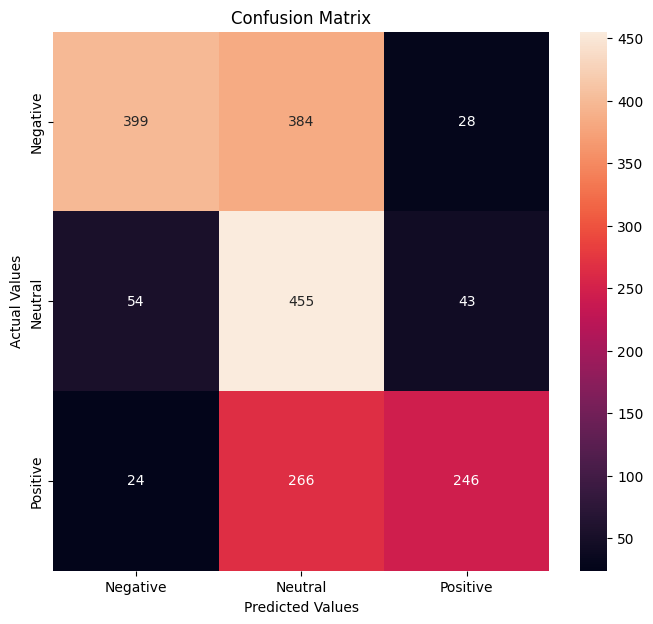

<Figure size 640x480 with 0 Axes>

In [123]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pred_name_values = test_df.pred_name.values
label_values = test_df.label_name.values
cm = confusion_matrix(label_values, pred_name_values)
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
plt.figure(figsize=(8,7))
sns.heatmap(cm_df, annot=True,fmt=".0f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

plt.savefig('cm_test_predictions.png')

In [127]:
test_df.sample(10)

,text,label,label_name,text_original,tokenized_text,sent_token_length,sent_bert_token_length,char_count,Character Count,pred,pred_name
1028,maría pia estás regia y súper pilas que sigan tus éxitos💯💯💯,2,Positive,María Pia estás Regia y Súper Pilas que sigan tus Éxitos💯💯💯💯💯💯💯💯💯,maría pia estás regia y súper pilas que sigan tus éxitos💯💯💯,11,12,59,59,2,Positive
515,grande mambo park todas grandes voleibolistas ejemplos a seguir en mi opinión pero con la que me identifico más es un natalia málaga por su exigencia su disciplina... me considero yo una gran voleibolista hasta ahora ya no juego pero considero haber tenido un gran profesor en lo que se refiere a...,1,Neutral,Grande Mambo Park todas grandes voleibolistas ejemplos a seguir en mi opinión pero con la que me identifico más es un Natalia Málaga por su exigencia su disciplina...... me considero yo una gran voleibolista hasta ahora ya no juego pero considero haber tenido un gran profesor en lo que se refier...,grande mambo park todas grandes voleibolistas ejemplos a seguir en mi opinión pero con la que me identifico más es un natalia málaga por su exigencia su disciplina me considero yo una gran voleibolista hasta ahora ya no juego pero considero haber tenido un gran profesor en lo que se refiere a...,79,95,483,483,2,Positive
649,aparte de : rondero profesor campesino evangelista astronauta testigo de jehova apostador ahora es tecladista 😬🥺🤣,1,Neutral,Aparte de : Rondero Profesor Campesino Evangelista Astronauta Testigo de Jehova Apostador Ahora es Tecladista 😬🥺🤣,aparte de rondero profesor campesino evangelista astronauta testigo de jehova apostador ahora es tecladista 😬🥺🤣,16,23,113,113,0,Negative
47,"gracioso ja,ja,ja,la cara de la china 😁",1,Neutral,"Gracioso ja,ja,ja,la cara de la china 😁",gracioso ja ja ja la cara de la china 😁,7,10,39,39,0,Negative
387,mike lp jarly m. reyes cómo cuando luis eduardo muñoz gutierrez llegaba con tabas nuevas auspiciadas por lucas 😁,1,Neutral,Mike Lp Jarly M. Reyes Cómo cuando Luis Eduardo Muñoz Gutierrez llegaba con tabas nuevas auspiciadas por Lucas 😁,mike lp jarly m reyes cómo cuando luis eduardo muñoz gutierrez llegaba con tabas nuevas auspiciadas por lucas 😁,19,25,112,112,1,Neutral
1796,ya pues beto tampoco tampocooo!!! ya pareces más bien su jefe o jefa de propaganda suelta a esa pulpina calabaza 🎃,0,Negative,Ya pues Beto tampoco tampocooo!!!! Ya pareces más bien su jefe o jefa de propaganda Suelta a esa pulpina calabaza 🎃,ya pues beto tampoco tampocooo ya pareces más bien su jefe o jefa de propaganda suelta a esa pulpina calabaza 🎃,21,27,117,117,1,Neutral
1673,manquita pero mamacita 🤣😊 saludos desde colombia,2,Positive,Manquita pero mamacita 🤣😊 saludos desde Colombia,manquita pero mamacita 🤣😊 saludos desde colombia,7,10,49,49,1,Neutral
233,danny a. hancco cómo todo un profesional 😅😅😅,2,Positive,Danny A. Hancco cómo todo un profesional 😅😅😅😅,danny a hancco cómo todo un profesional 😅😅😅,8,10,45,45,1,Neutral
161,"noheli d'france gutierrez ñahuis, sobretodo la de las antenas de cucaracha 🤣🤣🤣",0,Negative,"Noheli D'france Gutierrez Ñahuis, sobretodo la de las antenas de cucaracha 🤣🤣🤣",noheli d france gutierrez ñahuis sobretodo la de las antenas de cucaracha 🤣🤣🤣,12,22,78,78,1,Neutral
834,huaral lo mejor eso que no fuiste ala parte sierra de huaral 💯,2,Positive,Huaral lo mejor eso que no fuiste ala parte sierra de huaral 💯,huaral lo mejor eso que no fuiste ala parte sierra de huaral 💯,13,17,62,62,1,Neutral


In [114]:
test_df.to_csv('test_inference.csv', columns=['text', 'label','label_name', 'char_count', 'pred', 'pred_name'])

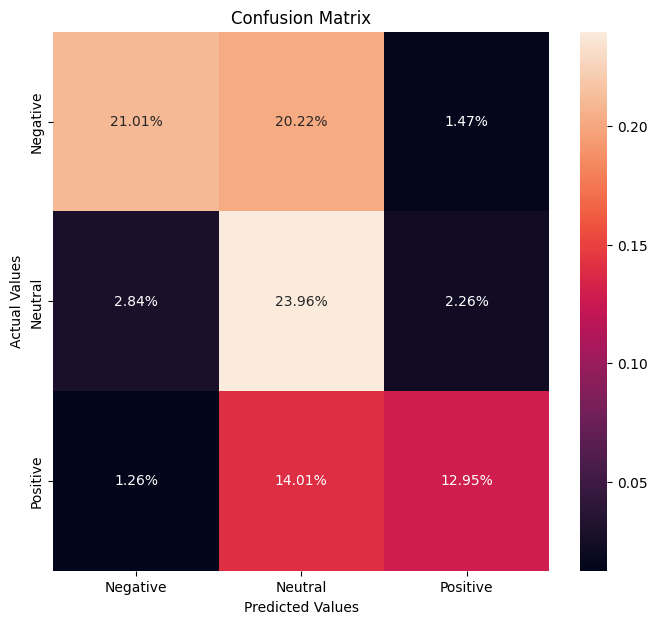

In [134]:
cm = confusion_matrix(label_values, pred_name_values)
cm_df = pd.DataFrame(cm/np.sum(cm),
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
plt.figure(figsize=(8,7))
sns.heatmap(cm_df, annot=True, fmt=".2%")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.savefig('cm_test_predictions_percentage.png')
plt.show()